In [1]:
# @Author : Vasantha HR

import dlib
# print(dlib)

In [2]:
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Layer

import tensorflow as tf

import cv2

Using TensorFlow backend.


In [3]:
from model import create_model

In [4]:
def triplet_loss(y_true, y_pred, alpha = 0.3):
       
#         f_a= y_pred[0]
#         f_p= y_pred[1]
#         f_n= y_pred[2]
#         positive_dist= K.sum(K.square(f_a-f_p), axis=-1)
#         negative_dist= K.sum(K.square(f_a-f_n), axis=-1)
#         loss= K.sum(K.maximum(positive_dist - negative_dist + alpha, 0), axis=0)
        
#         return loss

    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    # Step 1: Compute the (encoding) distance between the anchor and the positive, you will need to sum over axis=-1
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=-1)
    # Step 2: Compute the (encoding) distance between the anchor and the negative, you will need to sum over axis=-1
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=-1)
    # Step 3: subtract the two previous distances and add alpha.
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
    # Step 4: Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0.0))
    
    return loss

        
trained_model= create_model()

trained_model.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])


trained_model.load_weights('weights/binary/nn4_v2.v1.h5')

#the above code would be used only when we use data_generator: means once we pass data samples throug 
#trained_model.fit_generator(), then it would keep on evaluating loss function to optimize its cost value.

#$$$$$$$$$$$$$$
#But as of now, I used already trained_model just to get prediction value(anchor)in vector format 
#and then pass it to SVM Model (SVC)

In [5]:
import numpy as np
import os.path
import matplotlib.pyplot as plt


class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
#         print("call __repr", )
        val= self.image_path()
#         print("self.image_path()====>",val)
        return val

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
#                 print("what val", IdentityMetadata(path, i, f))
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata('images_folder')
# print(metadata)
# f= open("ttt.txt",'w',encoding='utf8')
# f.write(metadata)
# f.close()
# # print(metadata)


# foo = np.array(metadata)
# with open('file'+'_2', 'wb') as abc:
#     np.savetxt(abc, foo, delimiter=",")
    
##This works, if you want sae all these objects then use the below code to save it    
# import pickle

# with open('object_data.pkl', 'wb') as output:
#     pickle.dump(metadata, output, pickle.HIGHEST_PROTOCOL)

In [6]:
def process_image(image_path):
    image= cv2.imread(image_path, 1)
    
#reverse the color image, BGR to RGB
    image= image[...,::-1]
    
    return image

def dlib_identify_select_face__image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), 
                           landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

In [13]:
from align import AlignDlib


# Initialize the OpenFace face alignment utility, using Dlib andmardk for face detection, dat
alignment = AlignDlib('dlib/landmarks.dat')

inpt_img_features = np.zeros((metadata.shape[0], 128))

print(metadata.shape[0]," overal shape",metadata.shape)

for ind, data in enumerate(metadata):
#     print("test",ind)
#     print(data)
    image= process_image(data.image_path())
    image= dlib_identify_select_face__image(image)
    # Normalize RGB values to interval [0,1]
    image = (image / 255).astype(np.float32)

    inpt_img_features[ind] =  trained_model.predict(np.expand_dims(image, axis=0))[0]  #get anchor value , this is 128 features in vector format
    

46  overal shape (46,)


In [8]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import f1_score, accuracy_score

labels= [val.name for val in metadata]

hot_encoding= LabelEncoder()
hot_encoding.fit(labels)

#final hot encoder as follows

y_encoded= hot_encoding.transform(labels)

#getting indexes, finally 50% of train and 50% of test images
train_index = np.arange(metadata.shape[0]) % 2 == 0
test_index = np.arange(metadata.shape[0]) % 2 != 0

train_x = inpt_img_features[train_index]
test_x = inpt_img_features[test_index]

train_y = y_encoded[train_index]
test_y = y_encoded[test_index]

svc = LinearSVC()

svc.fit(train_x, train_y)

#to test accuracy
# accuracy = accuracy_score(test_y, svc.predict(test_x))

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

Text(0.5,1,'Recognized as:: Mark_Zuckerberg')

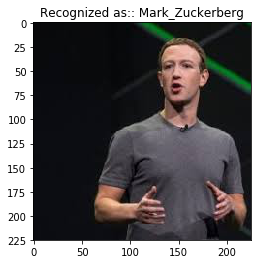

In [12]:
import warnings
warnings.filterwarnings('ignore')

index_test= 35 #Mark_Zuckerberg
# print("path:::",metadata[index_test].image_path())
# print("vector:::",inpt_img_features[index_test])
test_image = process_image(metadata[index_test].image_path()) #color image 
test_prediction = svc.predict([inpt_img_features[index_test]])
test_output_label = hot_encoding.inverse_transform(test_prediction)[0]

plt.imshow(test_image)

plt.title("Recognized as:: "+test_output_label)

In [10]:
#save the model

from sklearn.externals import joblib

# save the model to disk
filename = 'saved_model\svc_classifier_v1.sav'
joblib.dump(svc, filename)


['saved_model\\svc_classifier_v1.sav']